In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.api import tsa

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

This notebook is about time series and using [AR](http://www.statsmodels.org/dev/generated/statsmodels.tsa.ar_model.AR.html) and [ARMA](http://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARMA.html?highlight=arma) models we will try to predict the next few days price of Bitcoin!        
First things first, getting the data. You can download daily closing price of all major crypto-currencies from [here](https://www.coindesk.com/price/). Click on the 'Export' button on the top right hand side of the chart and you can download the data as a CSV file.

The data used in this notebook can also be found under the [data folder](https://github.com/jessgess/Time_Series_Analysis_ARIMA/blob/master/data/bitcoin_USD_close_data-2017-02-09_2018-02-09.csv) of this repo. 

In [2]:
#Loading the data
data = pd.read_csv('data/bitcoin_USD_close_data-2017-02-09_2018-02-09.csv',
                   parse_dates=['Date'])
print(data.shape)
data.tail()

(366, 2)


,Date,Price
361,2018-02-05,6914.26
362,2018-02-06,7700.39
363,2018-02-07,7581.80
364,2018-02-08,8237.24
365,2018-02-09,8689.84


We can format the `Date` column and use its unique values as index.

In [3]:
data['Date'] = data['Date'].dt.date
data.set_index(pd.to_datetime(data['Date']), inplace=True)
data.drop('Date', axis=1, inplace=True)
data.head()

,Price
Date,
2017-02-09,988.95
2017-02-10,993.08
2017-02-11,1010.00
2017-02-12,999.51
2017-02-13,996.86


Next thing plotting the data to get the general feel of our series.

<Axes: xlabel='Date'>

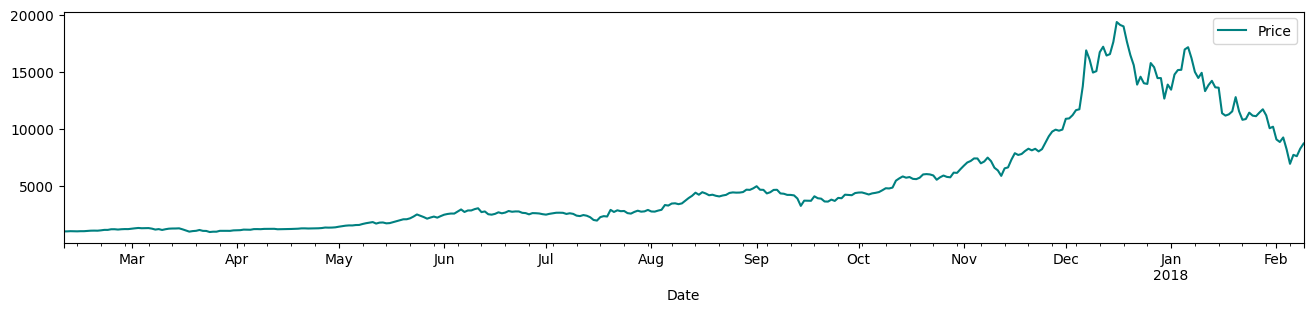

In [4]:
data.plot(y='Price', color='teal', figsize=(16,3))

Its clear from the plot that there was a constant upward trend all the way to mid December and then a sharp drop in the price followed by a spark earlier in January, but in general price was going down in 2018.<br/> 
To better capture the trend of data you can always resample the data by taking biweekly, weekly, monthly or yearly average. 

/tmp/ipykernel_783029/464736255.py:1: FutureWarning: The provided callable <function mean at 0x763c885c1580> is currently using DatetimeIndexResampler.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  price_weekly_avg = data.resample('W').apply(np.mean)
/tmp/ipykernel_783029/464736255.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  price_monthly_avg = data.resample('M').apply(np.mean)
/tmp/ipykernel_783029/464736255.py:2: FutureWarning: The provided callable <function mean at 0x763c885c1580> is currently using DatetimeIndexResampler.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  price_monthly_avg = data.resample('M').apply(np.mean)


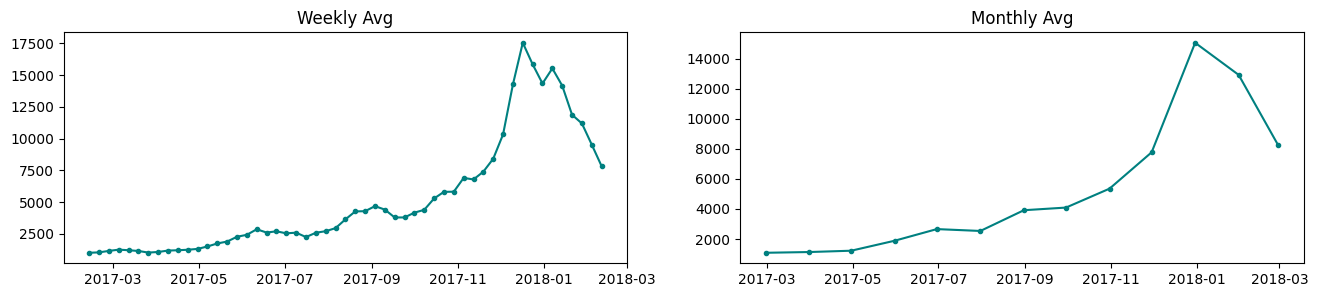

In [5]:
price_weekly_avg = data.resample('W').apply(np.mean)
price_monthly_avg = data.resample('M').apply(np.mean)
plt.figure(figsize=(16,3))
plt.subplot(121)
plt.title('Weekly Avg')
plt.plot(price_weekly_avg.Price, "-o", markersize=3, color='teal')
plt.subplot(122)
plt.title('Monthly Avg')
plt.plot(price_monthly_avg.Price, "-o", markersize=3, color='teal')

Checking the above graph for monthly average, we can see that it confirms our observation earlier on about the trend of the data. Another way of capturing the trend is through rolling average which we will do below. Basically we take a window of consecutive data points, in our case this is a daily frequency, calculate the average of them, and replace the whole window by that average, either at the extreme right or at the center of the window. So window of 7 is the same as weekly average: 

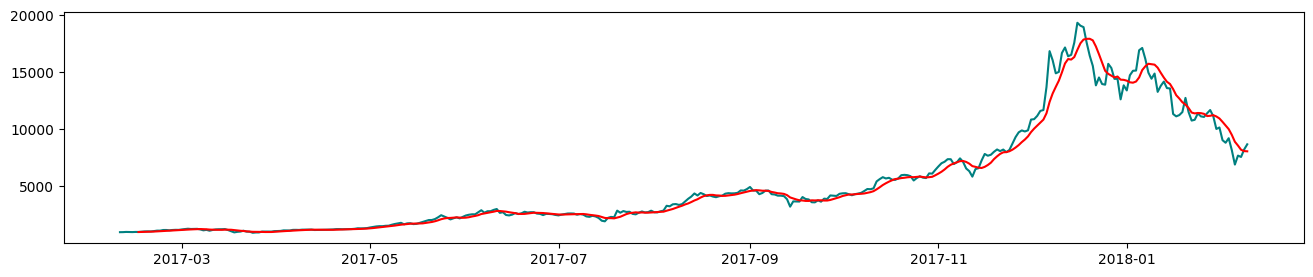

In [6]:
rolling_mean = data.Price.rolling(window=7, center=False).mean() #window of 7 (weekly avg) captures our data better 
plt.figure(figsize=(16,3))
plt.plot(data.Price, color='teal')
plt.plot(rolling_mean, 'red') 

### Making the data stationary and autocorrelation 

After some initial explorations its now time to create our model. For that we first need to make the series stationary as this is a prerequisite for most of the models.
Making the data stationary means taking the trend out of it (de-trending the data) in order to have its statistical properties (i.e. mean, variance) constant over time. This will help the sample to be more predictable by the model since it can be assumed that the statistical properties of the data will be the same in the future as they were in the past. 
One way of stationarising a time series is through differencing, that is taking the difference of two data points within a specified period, this period is called lag.  
In order to find the optimal lag we use [autocorerlation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.autocorr.html) method. 

Autocorrelation measures the correlation (similarity) between the time series and a lagged version of itself. Below we define varies lag values to see which one causes the highest correlation.

Text(0, 0.5, 'Autocorrelation')

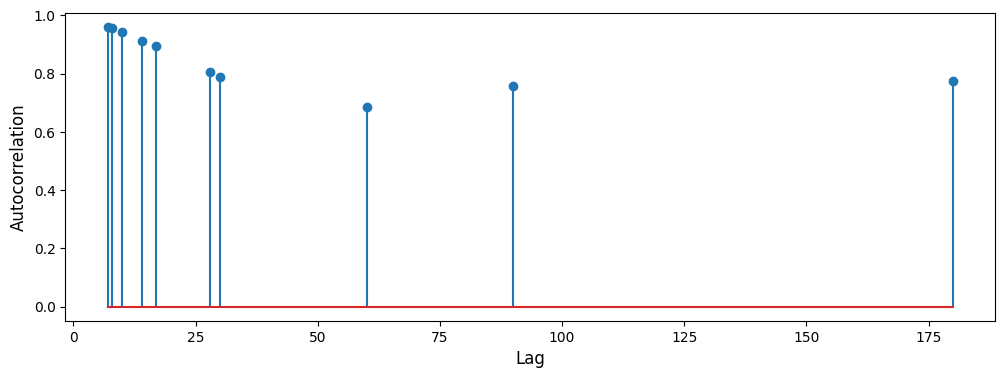

In [7]:
lags = [7, 8, 10, 14, 17, 28, 30, 60, 90, 180] 
autocorrs = [data.Price.autocorr(lag=lag) 
                   for lag in lags]
plt.figure(figsize=(12, 4))
plt.stem(lags, autocorrs)
plt.xlabel("Lag", fontsize=12)
plt.ylabel("Autocorrelation", fontsize=12)

Based on the above graph the highest correlation occurs at lag of 7, that means the data repeats a pattern on a weekly basis. This is somewhat true of Bitcoin price as by experience I have seen the price going up throughout the week, normally hitting the highest point on the weekend then coming back down on Monday and repeating more or less the same cycle again...

Another way of checking the autocorrelation is through Pandas tools library. Running that we can see positive correlation for the first 100 lags with the most significant ones being the first 10 ones.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

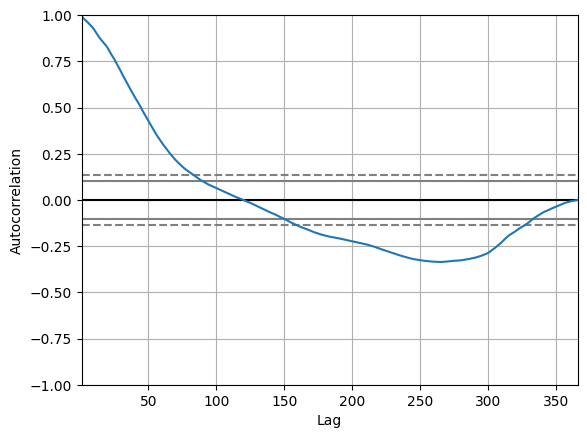

In [9]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(data) 

We can conclude that lag of 7 is a good candidate for the optimal lag. Let's plot the original series vs the lagged version of itself with difference of 7. This means each data point (starting from the 7th one) will be deducted from the data 7 days before that and plotted on the chart (orange line below).

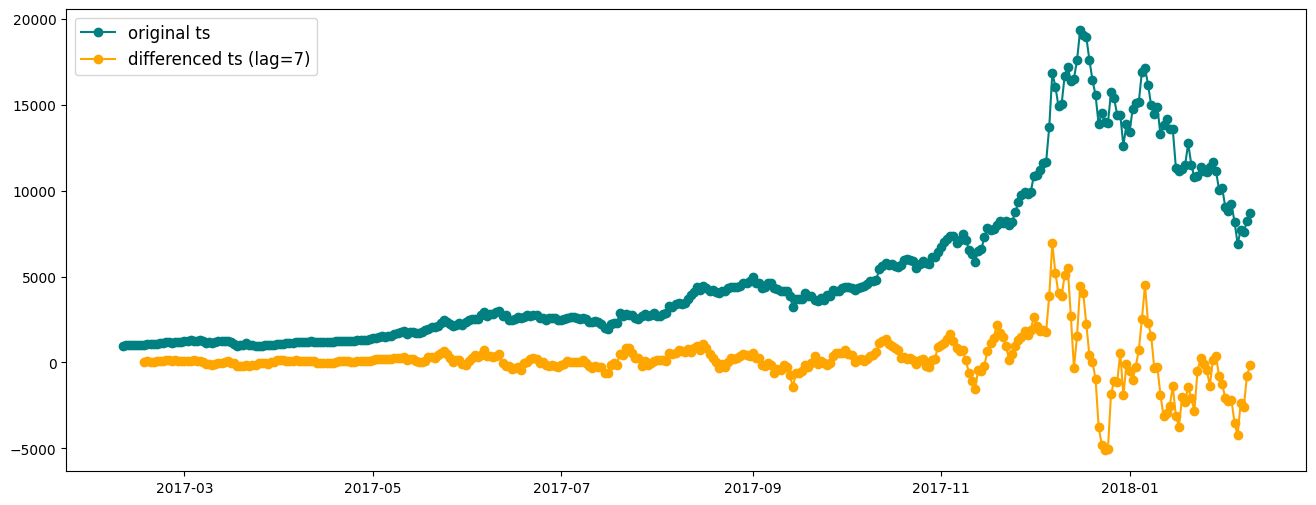

In [10]:
plt.figure(figsize=(16, 6))
plt.plot(data.Price, '-o', color='teal', label="original ts")
plt.plot(data.Price.diff(7), '-o', color='orange', label="differenced ts (lag=7)")
plt.legend(fontsize=12)


Now that we know what optimal lag to use to make a relatively stationary version of our original time series we can move on to next step which is training and fitting the models.

### Developing the models 

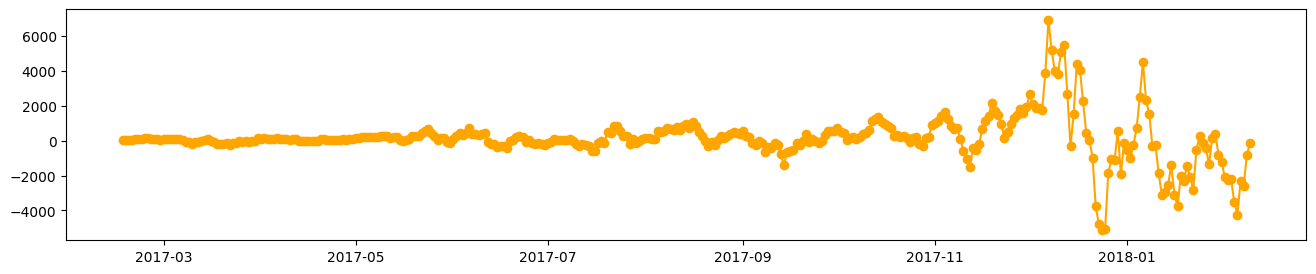

In [11]:
prices = data.Price
price_diff = prices.diff(7).dropna() 

plt.figure(figsize=(16,3))
plt.plot(price_diff, "-o", color='orange')

Above figure seems stationary enough so optlag=7 chosen for following operations

To start, lets save the stationary data into a new variable and call it `time_series`:

In [12]:
time_series = price_diff 

#### Now lets try with SKLearn linearRegression and then AR and ARMA models (time_series has not changed still diff=7)

For linear regression on time series we need to organize the data with matrix X where each row contains a forecast windiw and y is the target values for each row of X.

In [15]:
def organize_data(to_forecast, window, horizon=1):
    to_forecast = to_forecast.values  # Convert Series to numpy array
    shape = to_forecast.shape[:-1] + (to_forecast.shape[-1] - window + 1, window)
    strides = to_forecast.strides + (to_forecast.strides[-1],)
    X = np.lib.stride_tricks.as_strided(to_forecast,
                                        shape=shape,
                                        strides=strides)
    y = np.array([X[i+horizon][-1] for i in range(len(X)-horizon)])
    return X[:-horizon], y

lag = 90
X, y = organize_data(time_series, lag)

MAE = 241.978
MAE2 = 335.892


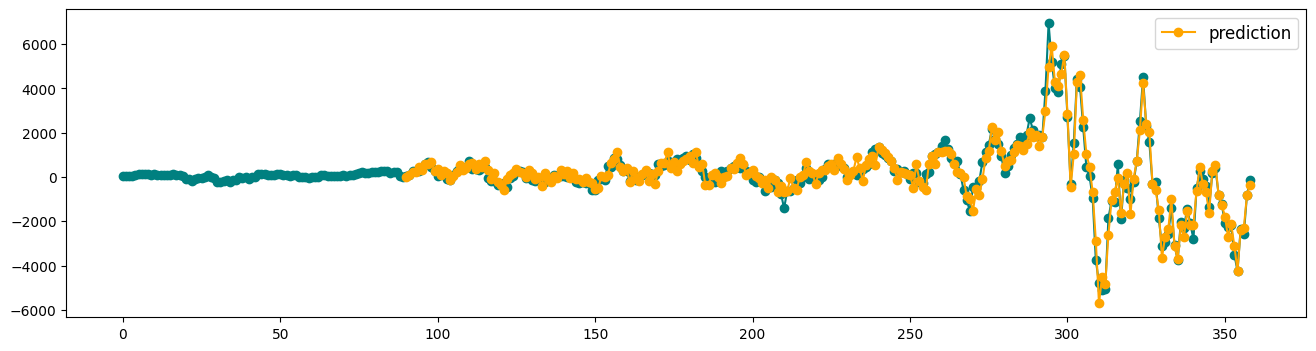

In [16]:
lr = LinearRegression()
lr_fit = lr.fit(X, y)
lr_prediction = lr_fit.predict(X)

plt.figure(figsize=(16, 4))
plt.plot(time_series.values, '-o', color='teal')
plt.plot(np.arange(lag, len(time_series)), lr_prediction, '-o', label='prediction', color='orange')
plt.legend(fontsize=12);

print('MAE = {0:.3f}'.format(mean_absolute_error(time_series[lag:], lr_prediction)))
print('MAE2 = {0:.3f}'.format(mean_absolute_error(time_series[-90:], lr_prediction[-90:]))) #for the last 90 days only

**AR Model**

AR stands for Auto-Regressive time series model where values are modeled as a linear combination of the _p_ past values therefore it's indicated as **AR(p)**. <br/>
_p_ defines the number of past observations that we would want the model to use to predict the next data and is also known as the lag order.
 
We can use `select_order` method to find the optimal value for _p_ as below, have in mind you will need to define `maxlag` which is the highest lag length to be tried out. **ic** is the criterion used for selecting the optimal lag, you can use different values for it defined in the [docs] (http://www.statsmodels.org/dev/generated/statsmodels.tsa.ar_model.AR.fit.html#statsmodels.tsa.ar_model.AR.fit) and see how those perform. I found 'aic' better for this task.

In [22]:
from statsmodels.tsa.ar_model import AutoReg

# Fit the AutoReg model
ar_model = AutoReg(time_series, lags=91)
ar_fit = ar_model.fit()
optlag = 91  # Using the lags value we specified in AutoReg(time_series, lags=91)
print("Best optimal lag for AR model: {}".format(optlag))

Best optimal lag for AR model: 91


/home/uzairwayne/.cache/pypoetry/virtualenvs/pgd-machine-learning-TOyQybo7-py3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Optimal lag for AR model: 47

Optimal _p_ value seems to be 47 days, having that we can train our model and see how it performs using mean absolute error (MAE) or mean of the residuals which is calculated as below, where _y_ and _x_ are predicted versus actual values per observation:


<center><img src="https://latex.codecogs.com/svg.latex?\Large&space;MAE=\frac{\sum_{i=1}^{n}|y_i \_ x_i|}{n}"/></center>


I am also printing out MAE_2 which is the mean absolute error only for the last 90 predictions as a fixed set to compare the results of this model with ARMA model later on.  



/home/uzairwayne/.cache/pypoetry/virtualenvs/pgd-machine-learning-TOyQybo7-py3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE = 259.015
MAE2 = 510.924


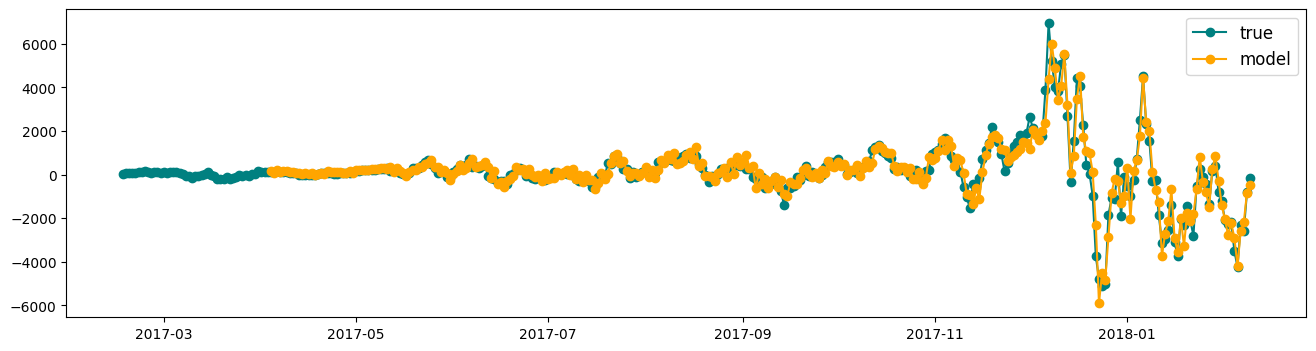

In [26]:
lag = 47 
ar = AutoReg(time_series, lags=lag)
ar_fit = ar.fit()
ar_prediction = ar_fit.predict(start=lag)

plt.figure(figsize=(16, 4))
plt.plot(time_series, '-o', label='true', color='teal')
plt.plot(ar_prediction, '-o', label='model', color='orange')
plt.legend(fontsize=12);

print('MAE = {0:.3f}'.format(mean_absolute_error(time_series[lag:], ar_prediction)))
print('MAE2 = {0:.3f}'.format(mean_absolute_error(time_series[-90:], ar_prediction[-90:]))) #error only for the last 90 days


**ARMA model**

ARMA stands for Autoregressive Moving Average. The difference between ARMA and AR is that the latter models a point in the time series as a linear model of the previous values, and treats the error between the actual data and the predictions as noise. But what if there could still be information in the series of errors? ARMA on the other hand includes the past errors as additional features to the model and is defined as **ARMA(p,q)**.

Just as the name suggests ARMA is comprised of two models, AR(p) (just like above) and MA(q) which is the moving average part and _q_ defines the number of moving average terms.<br/> Let's now run the model with p=7 and q=7 and see the results. You should also play around with these two variables and see the different results that they produce. 


In [27]:
arma = tsa.ARMA(time_series, order=(7, 7)) #7 p and 7 q for lag and moving average 
arma_fit = arma.fit()
start=100
arma_prediction = arma_fit.predict(start=start)

plt.figure(figsize=(16, 4))
plt.plot(time_series, '-o', label='true', color='teal')
plt.plot(arma_prediction, '-o', label='model', color='orange')
plt.legend();

print('MAE = {0:.3f}'.format(mean_absolute_error(time_series[start:], arma_prediction)))
print('MAE2 = {0:.3f}'.format(mean_absolute_error(time_series[-90:], arma_prediction[-90:]))) #error only for the last 90 days


AttributeError: module 'statsmodels.tsa.api' has no attribute 'ARMA'

### Now out of sample forcasting (the next 7 days)

So far we trained the models on the existing data and evaluated their performance by checking the mean absolute error of the predictions vs the actual values. Now that we have two trained models lets use them and predict the future (out of sample) values. 

Given that our AR model produced lower error, I will first use that to predict the future then will follow the same steps to predict the price with ARMA and then with ARIMA models.

Using the same optimal lag of 47, we predict 7 out of sample values. `end` argument of `predict` function, is where we define index of the last prediction we want to predict. This for 7 out of sample predictions will be the length of the series + 6.

In [7]:
#7 out of sample prediction with AR 
lag = 47
ar = tsa.AR(time_series)
ar_fit = ar.fit(maxlag=lag)
ar_forecast = ar_fit.predict(end=len(time_series)+6)[-7:] 
ar_forecast

2018-02-10    -654.683766
2018-02-11    -116.566214
2018-02-12    1158.861627
2018-02-13    1209.549713
2018-02-14    2028.570897
2018-02-15    1947.398843
2018-02-16    2259.390295
Freq: D, dtype: float64

In [9]:
#7 out of sample prediction with ARMA
arma = tsa.ARMA(time_series, order=(7, 7)) 
arma = arma.fit()
arma_forecast = arma.predict(end=len(time_series)+6)[-7:]
arma_forecast

C:\Users\ndadkhah\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\ndadkhah\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2018-02-10    -465.836826
2018-02-11     899.485866
2018-02-12    1557.258388
2018-02-13     882.516934
2018-02-14    1192.692812
2018-02-15     109.410093
2018-02-16     187.347293
Freq: D, dtype: float64

In [10]:
#and here ARIMA which is basically same thing as ARMA but in a slightly different implementation.
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(time_series, order=(7,0,7))
arima_fit = model.fit()
arima_forecast= arima_fit.forecast(steps=7)[0]
arima_forecast

C:\Users\ndadkhah\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\ndadkhah\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


array([ -465.83682587,   899.48586553,  1557.25838799,   882.5169341 ,
        1192.69281217,   109.41009282,   187.34729317])

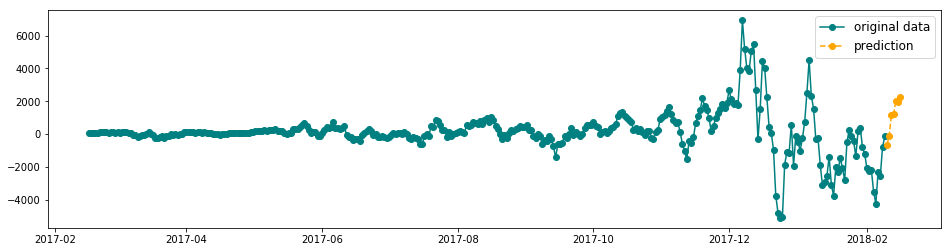

In [31]:
#AR model's 7 out of sample predictions
plt.figure(figsize=(16, 4))
plt.plot(time_series, '-o', label="original data", color='teal')
plt.plot(ar_forecast, '--o', label='prediction', color='orange')
plt.legend(fontsize=12)

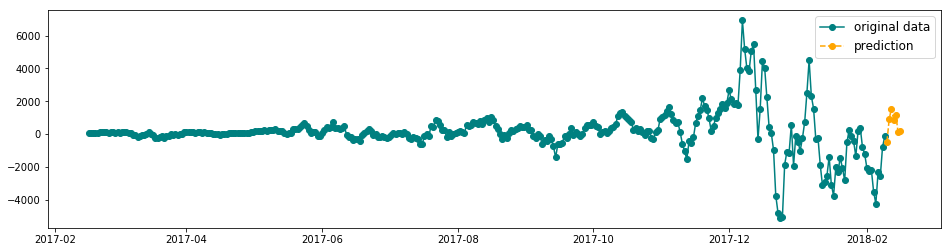

In [21]:
#ARMA model's 7 out sample predicitons 
plt.figure(figsize=(16, 4))
plt.plot(time_series, '-o', label="original data", color='teal')
plt.plot(arma_forecast, '--o', label='prediction', color='orange')
plt.legend(fontsize=12)

What we have predicted is not the actual future prices but the differenced values. Remember initially we made the data stationary by differencing with lag of 7? Now in order to find the actual future prices we need to reverse that process and change the series from stationary to the original form. For that we add each predicted value to the actual value 7 days before that. The last 7 days values in the original series were: 


In [8]:
print(prices[-7:]) #the actual last 7 sample prices

Date
2018-02-03    9224.39
2018-02-04    8186.65
2018-02-05    6914.26
2018-02-06    7700.39
2018-02-07    7581.80
2018-02-08    8237.24
2018-02-09    8689.84
Name: Price, dtype: float64


Having that, we calculate the actual values for the 7 out of sample predictions and plot them with the rest of the series:

In [9]:
idx = ar_forecast.index.values

forecast_prices = []
lag = 7
for i, diff in enumerate(ar_forecast): #choosing AR as it produced lower MAE than ARMA model
    prev_value = prices[-(lag)+i:][0]
    forecast_prices.append(prev_value+diff)
    
bitcoin_forecast = pd.Series(forecast_prices, index=idx)
bitcoin_forecast

2018-02-10     8569.706234
2018-02-11     8070.083786
2018-02-12     8073.121627
2018-02-13     8909.939713
2018-02-14     9610.370897
2018-02-15    10184.638843
2018-02-16    10949.230295
dtype: float64

And now plotting the full Bitcoin price chart including the 7 out of sample days:

<function matplotlib.pyplot.show>

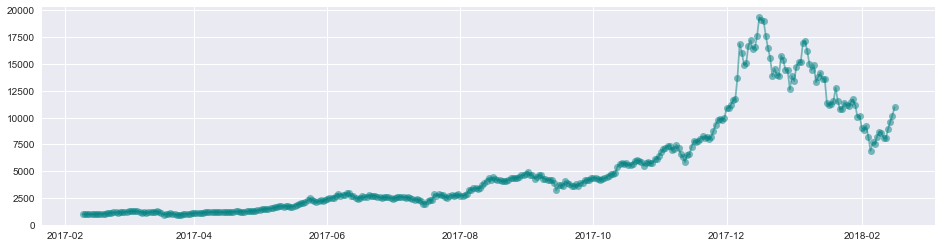

In [10]:
hist_values = data['Price'].append(bitcoin_forecast)

plt.figure(figsize=(16,4))
plt.plot(hist_values, '-o', color='teal', alpha=0.5)
plt.show

____________________________________________________________________________________________________________________________-

Now reality check with actual prices form coindesk for our out of sample dates:

In [11]:
real_price = pd.DataFrame(data={"price":[8556.61, 8070.8, 8891.21, 8516.24, 9477.84, 10016.49, 10178.71],
                          "dates":['2018-02-10', '2018-02-11', '2018-02-12', '2018-02-13', '2018-02-14', '2018-02-15',
                               '2018-02-16']})

real_price.set_index(pd.to_datetime(real_price['dates']), inplace=True)
real_price.drop('dates', axis=1, inplace=True)
real_price

,price
dates,
2018-02-10,8556.61
2018-02-11,8070.80
2018-02-12,8891.21
2018-02-13,8516.24
2018-02-14,9477.84
2018-02-15,10016.49
2018-02-16,10178.71


Below comparing the predicted values vs actual prices. Not too bad eh! :)

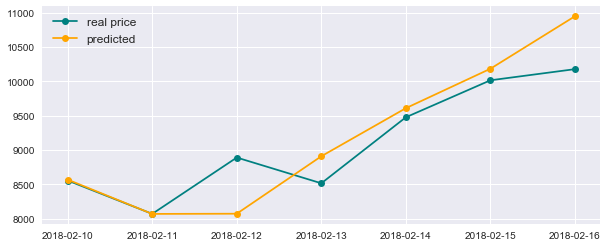

In [12]:
plt.figure(figsize=(10,4))
plt.plot(real_price, "-o", color="teal", label="real price")
plt.plot(bitcoin_forecast, "-o", color="orange", label="predicted")
plt.legend(fontsize=12)
plt.show()